In [1]:
import torch

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
import torch.nn as nn
import torch.functional as F

In [22]:
train_transform = transforms.Compose([(transforms.RandomChoice([transforms.RandomHorizontalFlip(),
                                                                            transforms.RandomVerticalFlip()])),
                                                   (transforms.GaussianBlur(kernel_size=(3,3))),
                                                   (transforms.ColorJitter(brightness=3,contrast = 10,saturation=3)),
                                                  (transforms.ToTensor()),
                                                 (transforms.Normalize(([0]),([1])))])

test_transform = transforms.Compose([(transforms.AutoAugment()),(transforms.ToTensor()),(transforms.Normalize(([0]),(1)))])

In [23]:
train_data = FashionMNIST(download = False,train = True,root = "/data",transform = train_transform)
test_data = FashionMNIST(root = "/data",download = False,transform = test_transform,train = False)

In [24]:
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size = 32,shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size = 32)

In [25]:
print(len(train_dataloader.dataset.classes),"classes\n",train_dataloader.dataset.classes)

10 classes
 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [54]:
for image,label in train_dataloader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [58]:
image,labels = next(iter(test_dataloader))

In [59]:
labels

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])

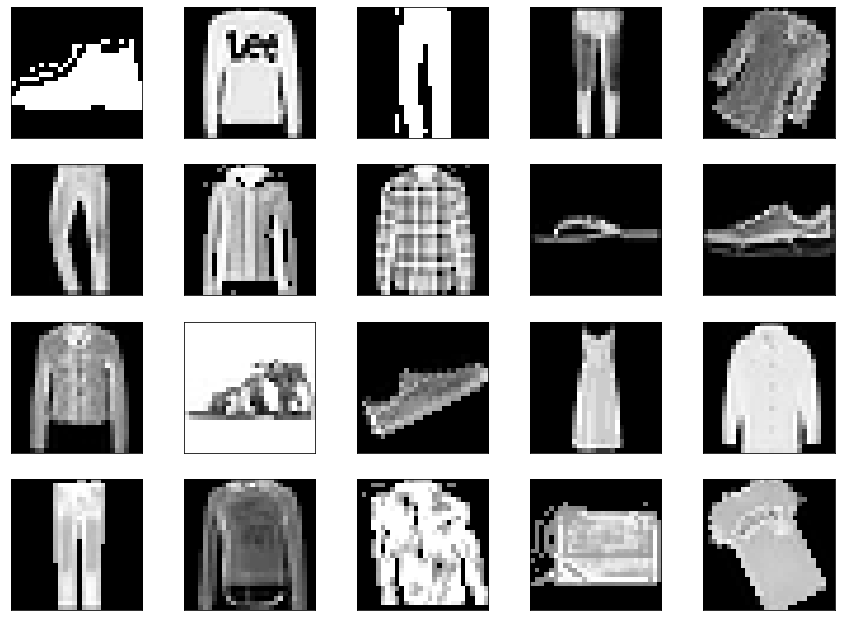

In [60]:
plt.figure(figsize=(15,14))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(image[i].numpy().squeeze(),plt.cm.gray)
    plt.xticks([]);plt.yticks([])

In [50]:
#this Notebook is for learning purposes, hence we will avoid the Sequential Method to make things a little clairer.

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size = (3,3),stride=2)
        self.relu =  nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2),stride = 2)
        self.fc1 = nn.Linear(in_features=12*6*6,out_features=500)
        self.fc2 = nn.Linear(in_features = 500,out_features=1000)
        self.fc3 = nn.Linear(in_features=1000,out_features=200)
        self.fc4 = nn.Linear(in_features = 200,out_features=10)
        
                
    def forward(self,image):
        image = self.conv1(image)
        image = self.relu(image)
        image = self.conv2(image)
        image = nn.Dropout(p = 0.5)(image)
        image = self.maxpool(image)

        image = image.view(image.size(0), -1)
        image = self.fc1(image)
        image = self.relu(image)
        image = self.fc2(image)
        image = self.relu(image)
        image = self.fc3(image)
        image = nn.Dropout(p = 0.5)(image)
        image = self.relu(image)
        image = self.fc4(image)
        
        #image = self.relu(image)
        
        return image

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("available device :: ",device)

available device ::  cpu


In [30]:
model = NeuralNet()
model.to(device)

optimizer = torch.optim.SGD(params = model.parameters(),lr = 0.01,momentum=0.01)
loss_fn = nn.CrossEntropyLoss()

In [33]:
def training_loop(dataloader,model,optimizer,loss_fn):
    
    training_accuracy,training_loss = 0,0
    total_batches = len(dataloader)
    total_size = len(dataloader.dataset)
    
    for batch,(image,labels) in enumerate(dataloader):
        
        #send features and targets to available device for gpu support
        image,labels = image.to(device),labels.to(device)
        
        #labels = labels.type(torch.long)
        
        #feed forward
        y_pred = model(image)
        
        loss = loss_fn(y_pred,labels) #compute the loss
        
        optimizer.zero_grad() #empty the gradient
        
        loss.backward() #compute the derivative of the loss with respect to the gradient (back propagation)
        
        optimizer.step()  #update the weight
        
        training_loss+= loss 
        
        accuracy = (y_pred.argmax(1)==labels).sum().type(torch.FloatTensor).item()
        
        training_accuracy+= accuracy
        
    training_accuracy/= total_size
    training_loss/= total_batches
    
    print(f'Training Loss >>> {(training_loss):.3f}')
    print(f'Training Accuracy >>> {(training_accuracy*100):.3f}%')

In [39]:
def testing_loop(dataloader,model,loss_fn):
    
    testing_loss,testing_accuracy = 0,0
    total_batches = len(dataloader)
    
    total_size = len(dataloader.dataset)
    with torch.no_grad():
        for (image,labels) in dataloader:

            image,labels = image.to(device),labels.to(device)

            y_pred = model(image)

            loss = loss_fn(y_pred,labels)

            accuracy = (y_pred.argmax(1)==labels).sum().type(torch.FloatTensor).item()

            testing_loss+= loss

            testing_accuracy+= accuracy

        testing_accuracy/= total_size
        testing_loss/= total_batches
    
    print(f"Testing Loss >>> (({testing_loss}):.3f)")
    print(f"Testing Accuracy >>> (({testing_accuracy*100}):.3f)%")

In [40]:
num_epochs = 5
for epochs in torch.arange(num_epochs):
    print(f"Epoch {epochs.item()}/{num_epochs}\n\n")
    print("Model Training  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    training_loop(train_dataloader,model,optimizer,loss_fn)
    print("Model Testing   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    testing_loop(test_dataloader,model,loss_fn)
print("Epochs Completed")

Epoch 0/5
Model Training  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Loss >>> 0.924
Training Accuracy >>> 64.510%
Model Testing   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Testing Loss >>> (1.4119315147399902:.3f)
Testing Accuracy >>> (57.78:.3f)%
Epoch 1/5
Model Training  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Loss >>> 0.869
Training Accuracy >>> 66.387%
Model Testing   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Testing Loss >>> (1.5211920738220215:.3f)
Testing Accuracy >>> (58.099999999999994:.3f)%
Epoch 2/5
Model Training  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Loss >>> 0.826
Training Accuracy >>> 67.678%
Model Testing   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Testing Loss >>> (1.4919939041137695:.3f)
Testing Accuracy >>> (58.120000000000005:.3f)%
Epoch 3/5
Model Training  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Loss >>> 0.804
Training Accuracy >>> 68.505%
Model Testing   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Testing Loss >>> (1.5633280277252197:.3f)
Testing Accuracy